In [261]:
import os
import shap
import pm4py as pm
import numpy as np
import pandas as pd
#------------------------------------------------------------------
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.inspection import permutation_importance
#------------------------------------------------------------------
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.conversion.log import converter as log_converter

# visualisations
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style("whitegrid")
sns.set(rc = {'figure.figsize':(15, 10)})

In [262]:
input_data_folder = "../orig_logs"
output_data_folder = "../input_files"
in_filename_xes = "Sepsis-Cases-Event-Log.xes"
in_filename_csv = "Sepsis-Cases-Event-Log.csv"

In [263]:
variant = xes_importer.Variants.LINE_BY_LINE
parameters = {variant.value.Parameters.TIMESTAMP_SORT: True}
log = xes_importer.apply(os.path.join(input_data_folder, in_filename_xes),
                         variant=variant, parameters=parameters)

In [264]:
dataframe = log_converter.apply(log, variant=log_converter.Variants.TO_DATA_FRAME)

In [265]:
dataframe.rename(columns={'case:concept:name': 'Case ID', 'concept:name': 'Activity', 
                          'time:timestamp': 'Complete Timestamp', 'org:group' : 'user'}, inplace=True)

In [266]:
dataframe.to_csv(os.path.join(input_data_folder, in_filename_csv))

In [267]:
case_id_col = "Case ID"
activity_col = "Activity"
timestamp_col = "Complete Timestamp"
label_col = "label"
pos_label = "deviant"
neg_label = "regular"

In [268]:
category_freq_threshold = 10

In [269]:
dynamic_cat_cols = ["Activity", 'user'] # i.e. event attributes
static_cat_cols = ['Diagnose', 'DiagnosticArtAstrup', 'DiagnosticBlood', 'DiagnosticECG',
       'DiagnosticIC', 'DiagnosticLacticAcid', 'DiagnosticLiquor',
       'DiagnosticOther', 'DiagnosticSputum', 'DiagnosticUrinaryCulture',
       'DiagnosticUrinarySediment', 'DiagnosticXthorax', 'DisfuncOrg',
       'Hypotensie', 'Hypoxie', 'InfectionSuspected', 'Infusion', 'Oligurie',
       'SIRSCritHeartRate', 'SIRSCritLeucos', 'SIRSCritTachypnea',
       'SIRSCritTemperature', 'SIRSCriteria2OrMore'] # i.e. case attributes that are known from the start
dynamic_num_cols = ['CRP', 'LacticAcid', 'Leucocytes']
static_num_cols = ['Age']

In [270]:
static_cols = static_cat_cols + static_num_cols + [case_id_col]
dynamic_cols = dynamic_cat_cols + dynamic_num_cols + [timestamp_col]
cat_cols = dynamic_cat_cols + static_cat_cols

In [271]:
# def extract_timestamp_features(group):
    
#     group = group.sort_values(timestamp_col, ascending=False, kind='mergesort')
    
#     tmp = group[timestamp_col] - group[timestamp_col].shift(-1)
#     #tmp = tmp.fillna(0)
#     #group["timesincelastevent"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'm'))) # m is for minutes
#     group["timesincelastevent"] = tmp.apply(lambda x: float(x / pd.Timedelta(1, 'm'))) # m is for minutes

#     tmp = group[timestamp_col] - group[timestamp_col].iloc[-1]
#     #tmp = tmp.fillna(0)
#     #group["timesincecasestart"] = tmp.apply(lambda x: float(x / np.timedelta64(1, 'm'))) # m is for minutes
#     group["timesincecasestart"] = tmp.apply(lambda x: float(x / pd.Timedelta(1, 'm'))) # m is for minutes

#     group = group.sort_values(timestamp_col, ascending=True, kind='mergesort')
#     group["event_nr"] = range(1, len(group) + 1)
    
#     return group

In [272]:
# def cut_before_activity(group):
#     relevant_activity_idxs = np.where(group[activity_col] == relevant_activity)[0]
#     if len(relevant_activity_idxs) > 0:
#         cut_idx = relevant_activity_idxs[0]
#         return group[:cut_idx]
#     else:
#         return group

In [273]:
def get_open_cases(date):
    return sum((dt_first_last_timestamps["start_time"] <= date) & (dt_first_last_timestamps["end_time"] > date))

In [274]:
# def check_if_activity_exists(group, activity):
#     relevant_activity_idxs = np.where(group[activity_col] == activity)[0]
#     if len(relevant_activity_idxs) > 0:
#         idx = relevant_activity_idxs[0]
#         group[label_col] = pos_label
#         return group[:idx]
#     else:
#         group[label_col] = neg_label
#         return group

In [275]:
# def check_if_activity_exists_and_time_less_than(group, activity):
#     relevant_activity_idxs = np.where(group[activity_col] == activity)[0]
#     if len(relevant_activity_idxs) > 0:
#         idx = relevant_activity_idxs[0]
#         if group["timesincelastevent"].iloc[idx] <= 28 * 1440: # return in less than 28 days (converted in minutes)
#             group[label_col] = pos_label #deviant

#             return group[:idx] #removes the activity in the scope
#         else:
#             group[label_col] = neg_label #regular

#             return group[:idx]
#     else:
#         group[label_col] = neg_label #regular

#         return group

In [276]:
def check_if_any_of_activities_exist(group, activities):
    if np.sum(group[activity_col].isin(activities)) > 0:
        return True
    else:
        return False

In [277]:
data = pd.read_csv(os.path.join(input_data_folder, in_filename_csv), sep=",")
data.rename(columns={"Unnamed: 0" : "event_nr"}, inplace=True)
data[case_id_col] = data[case_id_col].fillna("missing_caseid")

In [278]:
# remove incomplete cases
tmp = data.groupby(case_id_col).apply(check_if_any_of_activities_exist, activities=["Release A", "Release B", "Release C", "Release D", "Release E"])
incomplete_cases = tmp.index[tmp==False]
data = data[~data[case_id_col].isin(incomplete_cases)]

In [279]:
#columns = [static_cols + dynamic_cols]
#data = data.reindex(columns=columns)
data = data[static_cols + dynamic_cols]

In [280]:
# add features extracted from timestamp
# data[timestamp_col] = pd.to_datetime(data[timestamp_col], utc=True)
# data["timesincemidnight"] = data[timestamp_col].dt.hour * 60 + data[timestamp_col].dt.minute
# data["month"] = data[timestamp_col].dt.month
# data["weekday"] = data[timestamp_col].dt.weekday
# data["hour"] = data[timestamp_col].dt.hour
# data = data.groupby(case_id_col).apply(extract_timestamp_features)

In [281]:
# add inter-case features
data = data.sort_values([timestamp_col], ascending=True, kind='mergesort')
dt_first_last_timestamps = data.groupby(case_id_col)[timestamp_col].agg([min, max])
dt_first_last_timestamps.columns = ["start_time", "end_time"]
data["open_cases"] = data[timestamp_col].apply(get_open_cases)

In [282]:
# impute missing values
grouped = data.sort_values(timestamp_col, ascending=True, kind='mergesort').groupby(case_id_col)
for col in static_cols + dynamic_cols:
    data[col] = grouped[col].transform(lambda grp: grp.fillna(method='ffill'))

In [283]:
data[cat_cols] = data[cat_cols].fillna('missing')
data = data.fillna(0)

In [284]:
data.iloc[:3]

,Diagnose,DiagnosticArtAstrup,DiagnosticBlood,DiagnosticECG,DiagnosticIC,DiagnosticLacticAcid,DiagnosticLiquor,DiagnosticOther,DiagnosticSputum,DiagnosticUrinaryCulture,...,SIRSCriteria2OrMore,Age,Case ID,Activity,user,CRP,LacticAcid,Leucocytes,Complete Timestamp,open_cases
0,C,False,True,True,True,True,False,False,False,True,...,True,90.0,XJ,ER Registration,A,0.0,0.0,0.0,2013-11-07 08:18:29+01:00,1
1,C,False,True,True,True,True,False,False,False,True,...,True,90.0,XJ,ER Triage,C,0.0,0.0,0.0,2013-11-07 08:29:18+01:00,1
2,C,False,True,True,True,True,False,False,False,True,...,True,90.0,XJ,ER Sepsis Triage,A,0.0,0.0,0.0,2013-11-07 08:37:32+01:00,1


In [287]:
for col in cat_cols:
    counts = data[col].value_counts()
    mask = data[col].isin(counts[counts >= category_freq_threshold].index)
    data.loc[~mask, col] = "other"

In [257]:
data.shape

(13422, 32)

In [153]:
data.shape

(13422, 32)

Code Source : https://chrisalbon.com/code/machine_learning/trees_and_forests/feature_selection_using_random_forest/

In [163]:
# Source : https://github.com/erykml/medium_articles/blob/master/Machine%20Learning/feature_importance.ipynb

# function for creating a feature importance dataframe
def imp_df(column_names, importances):
    df = pd.DataFrame({'feature': column_names,
                       'feature_importance': importances}) \
           .sort_values('feature_importance', ascending = False) \
           .reset_index(drop = True)
    return df

# plotting a feature importance dataframe (horizontal barchart)
def var_imp_plot(imp_df, title):
    imp_df.columns = ['feature', 'feature_importance']
    sns.barplot(x = 'feature_importance', y = 'feature', data = imp_df, orient = 'h', color = 'royalblue') \
       .set_title(title, fontsize = 20)

In [164]:
#Removing the Columns which is not necessary

#_essencial_cols = ['Case ID', 'Complete Timestamp', 'user']

#additional_cols = ['timesincemidnight', 'month', 'weekday', 'hour', 'timesincelastevent', 'timesincecasestart']
#columns_to_drop = _essencial_cols + additional_cols
#print("Dropped Columns : ", columns_to_drop)
#data = data.drop(columns_to_drop, axis=1)
#Backup of data
#dataf = data

#dataf = data.drop(columns_to_drop, axis=1)

feature_cols = dynamic_num_cols + static_cat_cols + static_num_cols + ["Activity"]

dataf = data[feature_cols]

#Get the Numeric Columns so that Columns which is Catorical can be filtered out

data_list = dataf.columns

data_num_cols = dataf._get_numeric_data().columns

data_cat_cols = list(set(data_list) - set(data_num_cols))

In [165]:
dataf = dataf[~dataf.Diagnose.isin(['missing']) & ~dataf.DiagnosticArtAstrup.isin(['missing'])]

In [167]:
data_cat_cols

['InfectionSuspected',
 'SIRSCritHeartRate',
 'SIRSCritTemperature',
 'Oligurie',
 'DiagnosticLacticAcid',
 'DiagnosticECG',
 'Hypoxie',
 'DiagnosticXthorax',
 'SIRSCritTachypnea',
 'DiagnosticIC',
 'DiagnosticUrinarySediment',
 'DiagnosticArtAstrup',
 'Diagnose',
 'DiagnosticBlood',
 'Hypotensie',
 'Infusion',
 'DiagnosticUrinaryCulture',
 'SIRSCritLeucos',
 'DiagnosticSputum',
 'DiagnosticLiquor',
 'DisfuncOrg',
 'SIRSCriteria2OrMore',
 'Activity',
 'DiagnosticOther']

In [166]:
#for label encoding
data_cat_dict = {}
for i in range(len(data_cat_cols)):

    _label = data_cat_cols[i]
    temp_list = dataf[[_label]].values.tolist()
    subsec_set = {(x[0]) for x in temp_list}
    
    subsec_set = sorted(list(subsec_set))
    _index = dict()

    for ix, _ in enumerate(subsec_set):

        _index[subsec_set[ix]] = ix + 1
    
    _idx = lambda x: _index[x[_label]]
    
    #Actual Vlaues in the dictionary
    data_cat_dict[_label] = _index

    dataf[_label] = dataf.apply(_idx, axis=1)

In [109]:
# Labels are the values we want to predict
labels_activity = np.array(dataf['Activity'])

# Remove the labels from the features
# axis 1 refers to the columns
dataf = dataf.drop('Activity', axis = 1)
# Saving feature names for later use
data_list = list(dataf.columns)
# Convert to numpy array
#dataf = np.array(dataf) --removed

In [110]:
# Split the data into training and testing sets
train_features, test_features, train_labels, test_labels = train_test_split(dataf, labels_activity, test_size = 0.3, random_state = 42)

In [111]:
# Create a random forest classifier

slf = RandomForestClassifier(n_estimators = 1000,
                           n_jobs = -1, #-1 means using all processors to run in parallel
                           oob_score = True, #out-of-bag samples to estimate the generalization score
                           bootstrap = True, #bootstrap samples are used when building trees
                           random_state = 42)

slf.fit(train_features, train_labels)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, oob_score=True,
                       random_state=42)

In [112]:
print('R^2 Training Score: {:.2f} \nOOB Score: {:.2f} \nR^2 Validation Score: {:.2f}'.format(slf.score(train_features, train_labels), 
                                                                                    slf.oob_score_,
                                                                                    slf.score(test_features, test_labels)))

R^2 Training Score: 0.68 
OOB Score: 0.17 
R^2 Validation Score: 0.16


#### Default Feature Importance

In [113]:
base_imp = imp_df(train_features.columns, slf.feature_importances_)
base_imp

,feature,feature_importance
0,Leucocytes,0.276408
1,CRP,0.261449
2,LacticAcid,0.143870
3,Diagnose,0.096633
4,Age,0.076489
5,DiagnosticArtAstrup,0.017420
6,SIRSCritTachypnea,0.015834
7,DiagnosticUrinaryCulture,0.014861
8,DiagnosticUrinarySediment,0.013731
9,SIRSCritTemperature,0.008829


In [114]:
# Store the name and gini importance of each feature
feature_list = []
for feature in zip(data_list, slf.feature_importances_):
    feature_list.append(feature)
    
#feature to dictionary
result = dict(feature_list)
#sorting features
result = dict(sorted(result.items(), key=lambda item: item[1], reverse=True))

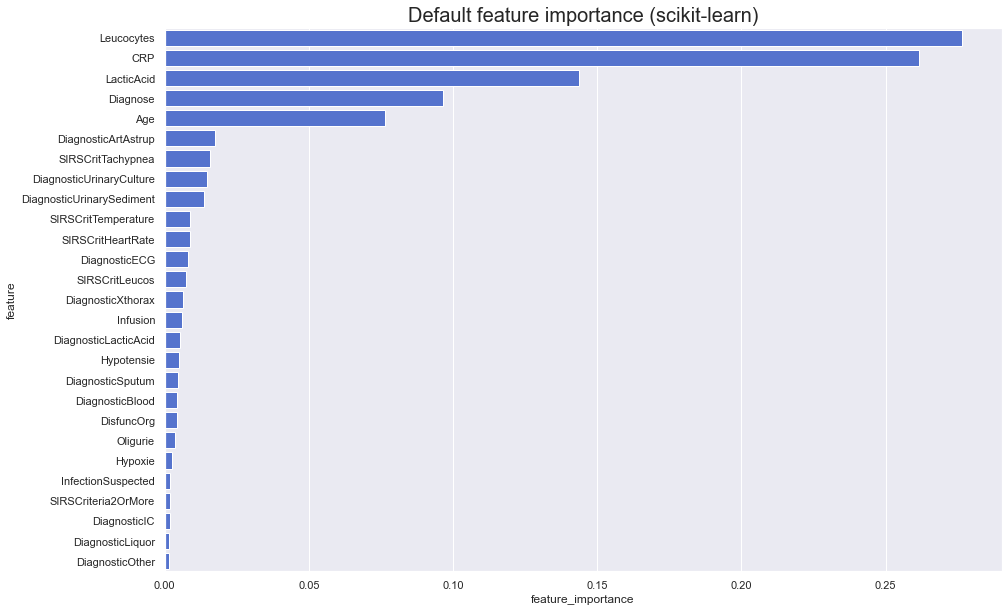

In [115]:
var_imp_plot(base_imp, 'Default feature importance (scikit-learn)')

when training a tree, it is possible to compute how much each feature decreases the impurity. The more a feature decreases the impurity, the more important the feature is. In random forests, the impurity decrease from each feature can be averaged across trees to determine the final importance of the variable. SelectFromModel will select those features which importance is greater than the *mean importance* of all the features by default

Few of the limitations of Random forest are :
- Correlated features will be given equal or similar importance, but overall reduced importance compared to the same tree built without correlated counterparts.
- Random Forests and decision trees, in general, give preference to features with high cardinality ( Trees are biased to these type of variables ).

In [116]:
# Create a selector object that will use the random forest classifier to identify
# “mean” is used by default.
sfm = SelectFromModel(slf)

# Train the selector
sfm.fit(train_features, train_labels)

SelectFromModel(estimator=RandomForestClassifier(n_estimators=1000, n_jobs=-1,
                                                 oob_score=True,
                                                 random_state=42))

In [117]:
# Print the names of the most important features
data_list_important = []
for feature_list_index in sfm.get_support(indices=True):
    print(data_list[feature_list_index])
    data_list_important.append(data_list[feature_list_index])

CRP
LacticAcid
Leucocytes
Diagnose
Age


In [118]:
# Transform the data to create a new dataset containing only the most important features
# Note: We have to apply the transform to both the training X and test X data.
X_important_train = sfm.transform(train_features)
X_important_test = sfm.transform(test_features)

In [119]:
# Create a new random forest classifier for the most important features
slf_important = RandomForestClassifier(n_estimators=1000, random_state=0, n_jobs=-1)

# Train the new classifier on the new dataset containing the most important features
slf_important.fit(X_important_train, train_labels)

RandomForestClassifier(n_estimators=1000, n_jobs=-1, random_state=0)

In [120]:
# Apply The Full Featured Classifier To The Test Data
y_pred = slf.predict(test_features)

# View The Accuracy Of Our Full Feature (4 Features) Model
accuracy_score(test_labels, y_pred)

0.1610148203968852

In [121]:
# Apply The Selected Featured Classifier To The Test Data
y_important_pred = slf_important.predict(X_important_test)

# View The Accuracy Of Our Limited Feature Model
accuracy_score(test_labels, y_important_pred)

0.1904044209997488

In [122]:
essencial_cols = ['Case ID', 'Activity', 'Complete Timestamp', 'user']

iter_cols = ['open_cases']

cols = essencial_cols + iter_cols + data_list_important

In [123]:
cols

['Case ID',
 'Activity',
 'Complete Timestamp',
 'user',
 'open_cases',
 'CRP',
 'LacticAcid',
 'Leucocytes',
 'Diagnose',
 'Age']

In [124]:
# # first labeling
# dt_labeled1 = data.sort_values(timestamp_col, ascending=True, kind="mergesort").groupby(case_id_col).apply(check_if_activity_exists_and_time_less_than, activity="Return ER")
# dt_labeled1[cols].to_csv(os.path.join(output_data_folder, "sepsis_cases_1.csv"), sep=",", index=False)

In [125]:
# # second labeling
# dt_labeled2 = data.sort_values(timestamp_col, ascending=True, kind="mergesort").groupby(case_id_col).apply(check_if_activity_exists, activity="Admission IC")
# dt_labeled2[cols].to_csv(os.path.join(output_data_folder, "sepsis_cases_2.csv"), sep=",", index=False)

In [126]:
# # fourth labeling
# dt_labeled3 = data.sort_values(timestamp_col, ascending=True, kind="mergesort").groupby(case_id_col).apply(check_if_activity_exists, activity="Release A")
# dt_labeled3[cols].to_csv(os.path.join(output_data_folder, "sepsis_cases_4.csv"), sep=",", index=False)

In [127]:
data[essencial_cols + ['open_cases'] + data_list_important].to_csv(os.path.join(output_data_folder, "sepsis_cases.csv"), sep=",", index=False)

Rest of the feature selection is based on the Mean Decrease Impurity and Mean Decrease Accuracy, usig the article :

https://blog.datadive.net/selecting-good-features-part-iii-random-forests/

https://stats.stackexchange.com/questions/191686/random-forests-for-optimal-variable-selection-feature-selection

https://towardsdatascience.com/explaining-feature-importance-by-example-of-a-random-forest-d9166011959e

#### Drop Column feature importance

In [128]:
from sklearn.base import clone 

def drop_col_feat_imp(model, train_features, train_labels, random_state = 42):
    
    # clone the model to have the exact same specification as the one initially trained
    model_clone = clone(model)
    # set random_state for comparability
    model_clone.random_state = random_state
    # training and scoring the benchmark model
    model_clone.fit(train_features, train_labels)
    benchmark_score = model_clone.score(train_features, train_labels)
    # list for storing feature importances
    importances = []
    
    # iterating over all columns and storing feature importance (difference between benchmark and new model)
    for col in train_features.columns:
        model_clone = clone(model)
        model_clone.random_state = random_state
        model_clone.fit(train_features.drop(col, axis = 1), train_labels)
        drop_col_score = model_clone.score(train_features.drop(col, axis = 1), train_labels)
        importances.append(benchmark_score - drop_col_score)
    
    importances_df = imp_df(train_features.columns, importances)
    return importances_df

In [129]:
drop_imp = drop_col_feat_imp(slf, train_features, train_labels)

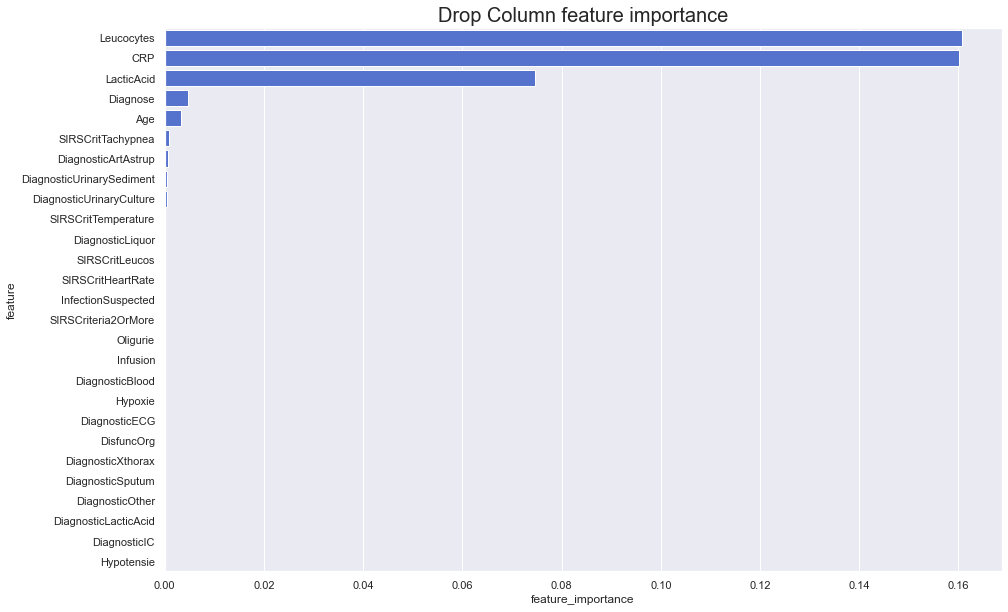

In [130]:
var_imp_plot(drop_imp, 'Drop Column feature importance')

#### Permutation Based Feature Importance

This method will randomly shuffle each feature and compute the change in the model’s performance. The features which impact the performance the most are the most important one. The permutation based method can have problem with highly-correlated features, it can report them as unimportant.

https://mljar.com/blog/feature-importance-in-random-forest/

In [135]:
perm_importance = permutation_importance(slf, train_features, train_labels)

In [136]:
sorted_idx = perm_importance.importances_mean.argsort()

TypeError: only size-1 arrays can be converted to Python scalars

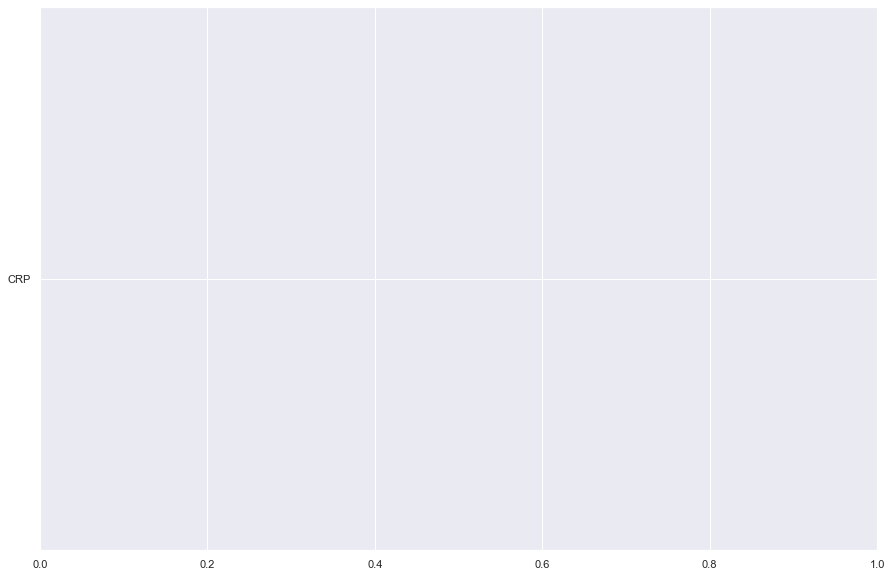

In [137]:
#perm_imp = imp_df(train_features.columns, perm_importance.feature_importances_)
plt.barh(train_features.columns, perm_importance.importances_mean[sorted_idx], 'Permutation Based Feature Importance').set_title(title, fontsize = 20)

In [141]:
#var_imp_plot(perm_imp, 'Default feature importance (scikit-learn)')

#### Feature Importance Computed with SHAP Values

It is using the Shapley values from game theory to estimate the how does each feature contribute to the prediction and it is model-agnostic

In [ ]:
#-- Commented because it takes lot of time

# explainer = shap.TreeExplainer(slf)
# shap_values = explainer.shap_values(train_features)

In [ ]:
# shap.summary_plot(shap_values, X_test, plot_type="bar")